In [ ]:
# 查看数据文件目录  list datalab files
!ls datalab/231718

In [2]:
# 查看个人永久空间文件  list files in your permanent storage
!ls /home/tianchi/myspace/


sub.csv


# 跨境电商数据探索

In [2]:
# 导入相关包
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import gc

pd.set_option('display.float_format',lambda x : '%.2f' % x)
plt.style.use('seaborn-dark') 
plt.rcParams['axes.unicode_minus']=False 
plt.rcParams['figure.figsize'] = (10.0, 5.0)
plt.rcParams['font.sans-serif'] = ['SimHei']

In [3]:
path = './datalab/231718/'
item = pd.read_csv(path+'Antai_AE_round1_item_attr_20190626.zip')
train = pd.read_csv(path+'Antai_AE_round1_train_20190626.zip')
test = pd.read_csv(path+'Antai_AE_round1_test_20190626.csv')

In [4]:
# 合并train和test文件
df = pd.concat([train.assign(is_train=1), test.assign(is_train=0)])
del train,test; gc.collect()

df['create_order_time'] = pd.to_datetime(df['create_order_time'])
df['date'] = df['create_order_time'].dt.date
df['day'] = df['create_order_time'].dt.day
df['hour'] = df['create_order_time'].dt.hour

df = pd.merge(df, item, how='left', on='item_id')

In [5]:
memory = df.memory_usage().sum() / 1024**2 
print('Before memory usage of properties dataframe is :', memory, " MB")

dtype_dict = {'buyer_admin_id' : 'int32', 
              'item_id' : 'int32', 
              'store_id' : 'int32',
              'irank' : 'int16',
              'item_price' : 'int16',
              'cate_id' : 'int16',
              'is_train' : 'int8',
              'day' : 'int8',
              'hour' : 'int8',
             }

df = df.fillna(0).astype(dtype_dict)
memory = df.memory_usage().sum() / 1024**2 
print('After memory usage of properties dataframe is :', memory, " MB")

Before memory usage of properties dataframe is : 1292.8728714  MB
After memory usage of properties dataframe is : 658.867905617  MB


In [8]:
df.head()

,buyer_country_id,buyer_admin_id,item_id,create_order_time,irank,is_train,date,day,hour,cate_id,store_id,item_price
0,xx,8362078,1,2018-08-10 23:49:44,12,1,2018-08-10,10,23,2324,10013,4501
1,xx,9694304,2,2018-08-03 23:55:07,9,1,2018-08-03,3,23,3882,4485,2751
2,yy,101887,3,2018-08-27 08:31:26,3,1,2018-08-27,27,8,155,8341,656
3,xx,8131786,3,2018-08-31 06:00:19,9,1,2018-08-31,31,6,155,8341,656
4,xx,9778613,5,2018-08-21 06:01:56,14,1,2018-08-21,21,6,1191,1949,1689


In [9]:
df.isnull().sum()

buyer_country_id     0
buyer_admin_id       0
item_id              0
create_order_time    0
irank                0
is_train             0
date                 0
day                  0
hour                 0
cate_id              0
store_id             0
item_price           0
dtype: int64

In [7]:
# 测试集和训练集
train = df['is_train']==1
test = df['is_train']==0
train_count = len(df[train])
print('训练集样本量是',train_count)
test_count = len(df[test])
print('测试集样本量是',test_count)
print('样本比例为：', train_count/test_count)

训练集样本量是 12868509
测试集样本量是 166832
样本比例为： 77.13453653975256


In [8]:
def groupby_cnt_ratio(df, col):
    if isinstance(col, str):
        col = [col]
    key = ['is_train', 'buyer_country_id'] + col
    cnt_stat = df.groupby(key).size().to_frame('count')
    ratio_stat = (cnt_stat / cnt_stat.groupby(['is_train', 'buyer_country_id']).transform(pd.Series.sum)).rename(columns={'count':'count_ratio'})
    return pd.merge(cnt_stat.reset_index(), ratio_stat.reset_index(), on=key, how='outer').sort_values(by=['count'], ascending=False)

In [16]:
groupby_cnt_ratio(df, [])

,is_train,buyer_country_id,count,count_ratio
1,1,xx,10635642,1.00
2,1,yy,2232867,1.00
0,0,yy,166832,1.00


Text(0.5,1,'国家编号')

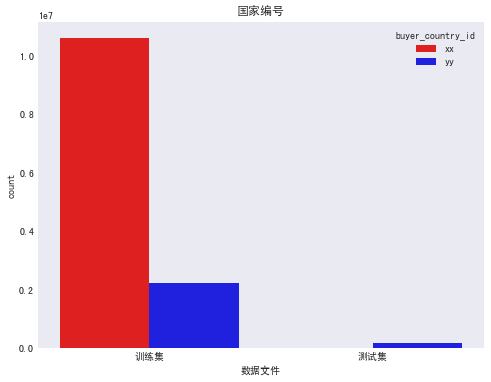

In [17]:
plt.figure(figsize=(8,6))
sns.countplot(x='is_train', data = df, palette=['red', 'blue'], hue='buyer_country_id', order=[1, 0])
plt.xticks(np.arange(2), ('训练集', '测试集'))
plt.xlabel('数据文件')
plt.title('国家编号')

In [18]:
print('训练集中用户数量',len(df[train]['buyer_admin_id'].unique()))
print('测试集中用户数量',len(df[test]['buyer_admin_id'].unique()))

训练集中用户数量 809213
测试集中用户数量 11398


In [19]:
union = list(set(df[train]['buyer_admin_id'].unique()).intersection(set(df[test]['buyer_admin_id'].unique())))
print('同时在训练集测试集出现的有6位用户，id如下：',union)

同时在训练集测试集出现的有6位用户，id如下： [12647969, 13000419, 3106927, 12858772, 12929117, 12368445]


In [20]:
# 用户购买统计
# 我们发现少数用户存在购买记录可达万级
admin_cnt = groupby_cnt_ratio(df, 'buyer_admin_id')
admin_cnt.head()

,is_train,buyer_country_id,buyer_admin_id,count,count_ratio
571677,1,xx,10828801,42751,0.00
574640,1,xx,10951390,23569,0.00
588533,1,xx,11223615,19933,0.00
574486,1,xx,10935073,13820,0.00
564598,1,xx,10683645,13210,0.00


In [21]:
# 用户购买记录数——最多、最少、中位数
admin_cnt.groupby(['is_train','buyer_country_id'])['count'].agg(['max','min','median'])

max  min  median
is_train buyer_country_id                    
0        yy                 1386    7      11
1        xx                42751    8      11
         yy                 3480    8      12

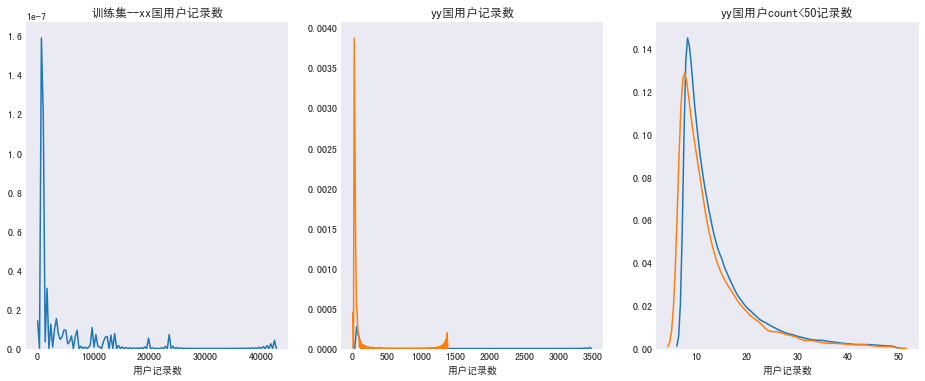

In [22]:
fig, ax = plt.subplots(1, 3 ,figsize=(16,6))
ax[0].set(xlabel='用户记录数')
sns.kdeplot(admin_cnt.loc[(admin_cnt['is_train'] == 1) & (admin_cnt['buyer_country_id'] == 'xx')]['count'].values, ax=ax[0]).set_title('训练集--xx国用户记录数')

ax[1].legend(labels=['训练集', '测试集'], loc="upper right")
ax[1].set(xlabel='用户记录数')
sns.kdeplot(admin_cnt.loc[(admin_cnt['is_train'] == 1) & (admin_cnt['buyer_country_id'] == 'yy')]['count'].values, ax=ax[1]).set_title('yy国用户记录数')
sns.kdeplot(admin_cnt.loc[(admin_cnt['is_train'] == 0) & (admin_cnt['buyer_country_id'] == 'yy')]['count'].values, ax=ax[1]).set_title('yy国用户记录数')

ax[2].legend(labels=['训练集', '测试集'], loc="upper right")
ax[2].set(xlabel='用户记录数')
sns.kdeplot(admin_cnt.loc[(admin_cnt['count']<50) & (admin_cnt['is_train'] == 1) & (admin_cnt['buyer_country_id'] == 'yy')]['count'].values, ax=ax[2]).set_title('yy国用户count<50记录数')
sns.kdeplot(admin_cnt.loc[(admin_cnt['count']<50) &(admin_cnt['is_train'] == 0) & (admin_cnt['buyer_country_id'] == 'yy')]['count'].values, ax=ax[2])

#图表看到，用户记录数大都都分布在0~50，少量用户记录甚至超过了10000条

In [23]:
print('商品表中商品数：',len(item['item_id'].unique()))
print('训练集中商品数：',len(df[train]['item_id'].unique()))
print('验证集中商品数：',len(df[test]['item_id'].unique()))
print('仅训练集有的商品数：',len(list(set(df[train]['item_id'].unique()).difference(set(df[test]['item_id'].unique())))))
print('仅验证集有的商品数：',len(list(set(df[test]['item_id'].unique()).difference(set(df[train]['item_id'].unique())))))
print('训练集验证集共同商品数：',len(list(set(df[train]['item_id'].unique()).intersection(set(df[test]['item_id'].unique())))))
print('训练集中不在商品表的商品数：',len(list(set(df[train]['item_id'].unique()).difference(set(item['item_id'].unique())))))
print('验证集中不在商品表的商品数：',len(list(set(df[test]['item_id'].unique()).difference(set(item['item_id'].unique())))))

商品表中商品数： 2832669
训练集中商品数： 2812048
验证集中商品数： 104735
仅训练集有的商品数： 2735801
仅验证集有的商品数： 28488
训练集验证集共同商品数： 76247
训练集中不在商品表的商品数： 7733
验证集中不在商品表的商品数： 313


In [24]:
# 商品统计
item_cnt = groupby_cnt_ratio(df, 'item_id')
item_cnt

,is_train,buyer_country_id,item_id,count,count_ratio
2381658,1,xx,12691565,112659,0.01
2382761,1,xx,12824199,35979,0.00
2381217,1,xx,12673275,14668,0.00
2384978,1,xx,12891086,12335,0.00
229843,1,xx,634028,7900,0.00
1956230,1,xx,10266898,6079,0.00
1918286,1,xx,10027998,5539,0.00
2263710,1,xx,12049470,5357,0.00
2382535,1,xx,12817558,4915,0.00
360711,1,xx,1359800,4708,0.00


In [25]:
top_item_plot = item_cnt.groupby(['is_train','buyer_country_id']).head(10)
top_item_plot

,is_train,buyer_country_id,item_id,count,count_ratio
2381658,1,xx,12691565,112659,0.01
2382761,1,xx,12824199,35979,0.00
2381217,1,xx,12673275,14668,0.00
2384978,1,xx,12891086,12335,0.00
229843,1,xx,634028,7900,0.00
1956230,1,xx,10266898,6079,0.00
1918286,1,xx,10027998,5539,0.00
2263710,1,xx,12049470,5357,0.00
2382535,1,xx,12817558,4915,0.00
360711,1,xx,1359800,4708,0.00


Text(0.5,1,'yy国-TOP热销商品')

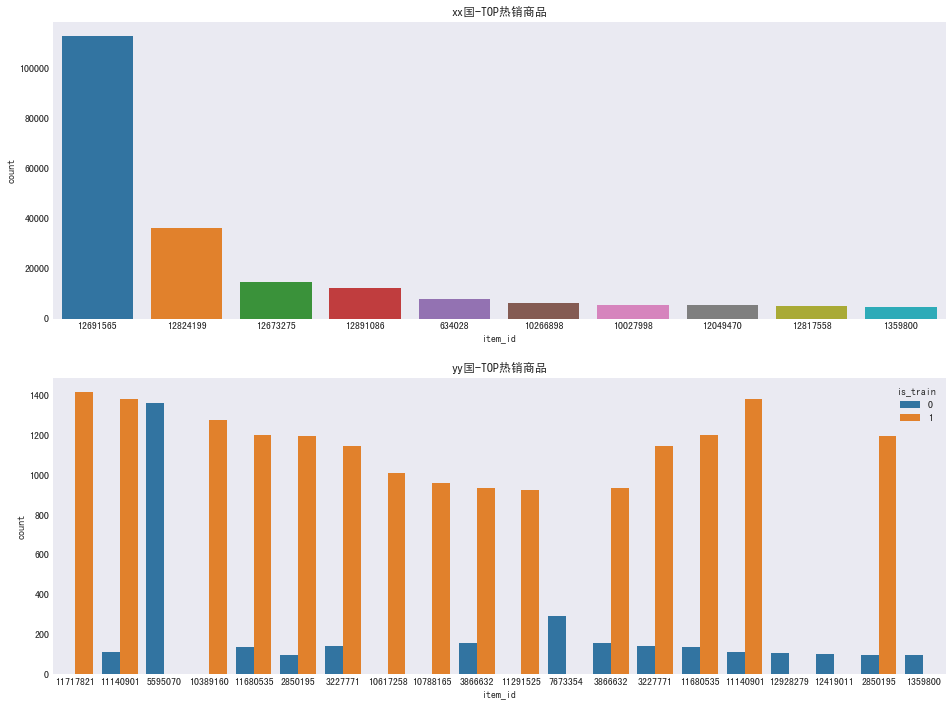

In [26]:
fig, ax = plt.subplots(2, 1, figsize=(16,12))
sns.barplot(x='item_id', y='count', data=top_item_plot[top_item_plot['buyer_country_id']=='xx'], 
            order=top_item_plot['item_id'][top_item_plot['buyer_country_id']=='xx'], ax=ax[0], estimator=np.mean).set_title('xx国-TOP热销商品')
sns.barplot(x='item_id', y='count', hue='is_train', data=top_item_plot[top_item_plot['buyer_country_id']=='yy'], 
            order=top_item_plot['item_id'][top_item_plot['buyer_country_id']=='yy'], ax=ax[1], estimator=np.mean).set_title('yy国-TOP热销商品')

In [34]:
item_cnt = item_cnt.rename(columns={'count':'销量'})
item_order_cnt = groupby_cnt_ratio(item_cnt, '销量')
item_order_cnt.head()

,is_train,buyer_country_id,销量,count,count_ratio
78,1,xx,1,1331056,0.58
1109,1,yy,1,625041,0.67
79,1,xx,2,361829,0.16
80,1,xx,3,164953,0.07
1110,1,yy,2,139607,0.15


In [35]:
item_order_plot = item_order_cnt.reset_index()
item_order_plot = item_order_plot[item_order_plot['销量']<=8]

xx_item_order_plot = item_order_plot[item_order_plot['buyer_country_id']=='xx']
yy_item_order_plot = item_order_plot[item_order_plot['buyer_country_id']=='yy']
yy_item_order_plot_1 = yy_item_order_plot[yy_item_order_plot['is_train']==1]
yy_item_order_plot_0 = yy_item_order_plot[yy_item_order_plot['is_train']==0]

In [37]:
print(xx_item_order_plot.head(10)['count_ratio'].sum())
print(yy_item_order_plot_1.head(10)['count_ratio'].sum())
print(yy_item_order_plot_0.head(10)['count_ratio'].sum())
#训练集中92%的商品销量不超过10件，而在测试集中97%的商品销量不超过10件

0.92155985915
0.96436660189
0.988466128801


In [43]:
print('商品品类数', len(item['cate_id'].unique()))
print('训练集商品品类数', len(df[train]['cate_id'].unique()))
print('测试集商品品类数', len(df[test]['cate_id'].unique()))
cate_cnt = item.groupby(['cate_id']).size().to_frame('count').reset_index()
cate_cnt.sort_values(by=['count'], ascending=False).head(5)

商品品类数 4243
训练集商品品类数 4239
测试集商品品类数 2727


,cate_id,count
578,579,170074
2395,2396,44467
1497,1498,42676
599,600,39729
1591,1592,34820


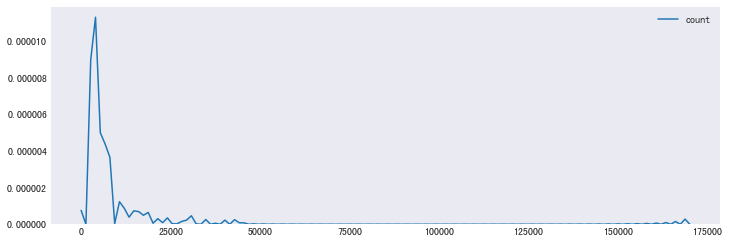

In [45]:
plt.figure(figsize=(12,4))
sns.kdeplot(data=cate_cnt['count'])

In [48]:
print('商品店铺数', len(item['store_id'].unique()))
print('训练集店铺数', len(df[train]['store_id'].unique()))
print('测试集店铺数', len(df[test]['store_id'].unique()))
store_cate_cnt = item.groupby(['store_id'])['cate_id'].nunique().to_frame('count').reset_index()
store_cate_cnt.sort_values(by=['count'], ascending=False).head(5)

商品店铺数 95105
训练集店铺数 94970
测试集店铺数 32930


,store_id,count
0,1,326
45594,45595,280
44983,44984,274
1870,1871,258
22034,22035,241


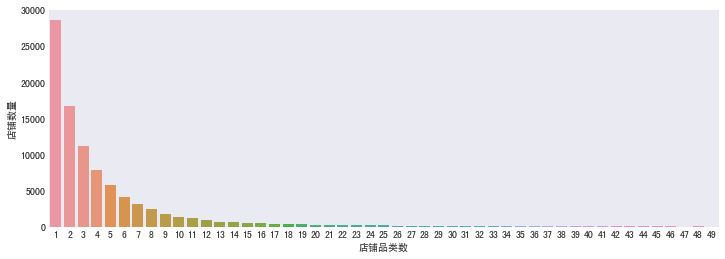

In [50]:
store_cnt_cate_cnt = store_cate_cnt.groupby(['count']).size().reset_index()
store_cnt_cate_cnt.columns = ['店铺品类数', '店铺数量']
plt.figure(figsize=(12,4))
sns.barplot(x='店铺品类数', y='店铺数量', data=store_cnt_cate_cnt[store_cnt_cate_cnt['店铺品类数']<50], estimator=np.mean)

In [51]:
store_item_cnt = item.groupby(['store_id'])['item_id'].nunique().to_frame('count').reset_index()
store_item_cnt.sort_values(by=['count'], ascending=False).head(5)

,store_id,count
0,1,6911
68671,68672,2435
33381,33382,2220
17544,17545,2053
82146,82147,2016


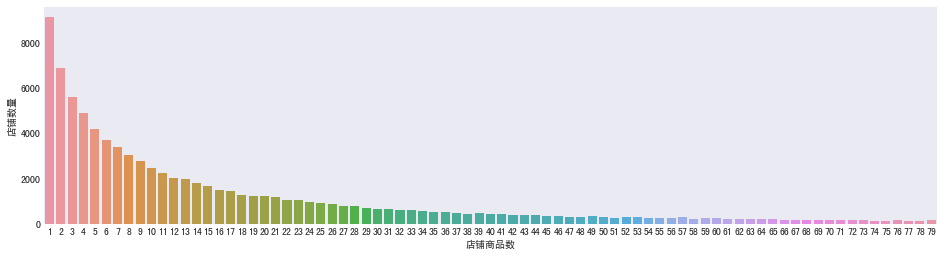

In [52]:
store_cnt_item_cnt = store_item_cnt.groupby(['count']).size().reset_index()
store_cnt_item_cnt.columns = ['店铺商品数', '店铺数量']
plt.figure(figsize=(16,4))
sns.barplot(x='店铺商品数', y='店铺数量', data=store_cnt_item_cnt[store_cnt_item_cnt['店铺商品数']<80], estimator=np.mean)

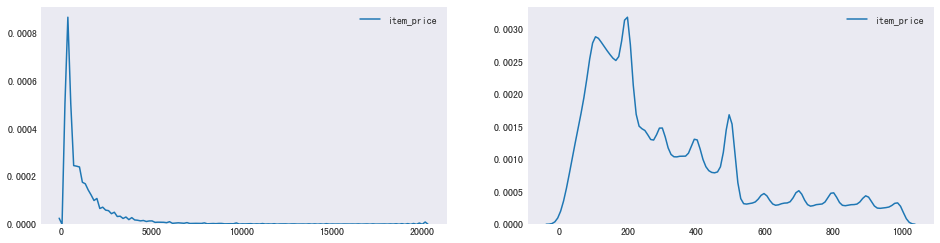

In [53]:
plt.figure(figsize=(16,4))
plt.subplot(121)
sns.kdeplot(item['item_price'])
plt.subplot(122)
sns.kdeplot(item['item_price'][item['item_price']<1000])

In [56]:
price_cnt = groupby_cnt_ratio(df, 'item_price')
price_cnt.groupby(['is_train', 'buyer_country_id']).head(5)

,is_train,buyer_country_id,item_price,count,count_ratio
5482,1,xx,200,404366,0.04
5782,1,xx,500,201061,0.02
5382,1,xx,100,186473,0.02
22031,1,xx,17844,114631,0.01
5403,1,xx,121,92956,0.01
24507,1,yy,200,82625,0.04
24807,1,yy,500,48651,0.02
24407,1,yy,100,38838,0.02
24607,1,yy,300,27452,0.01
24707,1,yy,400,24144,0.01


In [9]:
train_df_seven = df[train][df[train]['create_order_time']<pd.to_datetime('2018-08-01')]
train_df_eight = df[train][df[train]['create_order_time']>=pd.to_datetime('2018-08-01')]
train_df_seven = df[train][df[train]['create_order_time']<pd.to_datetime('2018-08-01')]
train_df_eight = df[train][df[train]['create_order_time']>=pd.to_datetime('2018-08-01')]

In [10]:
print('7月数据量',len(df[train][df[train]['create_order_time']<pd.to_datetime('2018-08-01')]),
      '\n8月数据量',len(df[train][df[train]['create_order_time']>pd.to_datetime('2018-08-02')]))

7月数据量 17856 
8月数据量 12838990


In [25]:
date_cnt = groupby_cnt_ratio(df, 'date')
date_cnt = date_cnt.rename(columns = {'count': '当天销量', 'count_ratio':'占比'}).sort_values(by=['date'], ascending=True)
date_cnt.head()

,is_train,buyer_country_id,date,当天销量,占比
46,1,xx,2018-07-13,20,0.00
96,1,yy,2018-07-14,12,0.00
47,1,xx,2018-07-14,42,0.00
48,1,xx,2018-07-15,149,0.00
97,1,yy,2018-07-15,16,0.00


Text(0.5,1,'yy国每日销量')

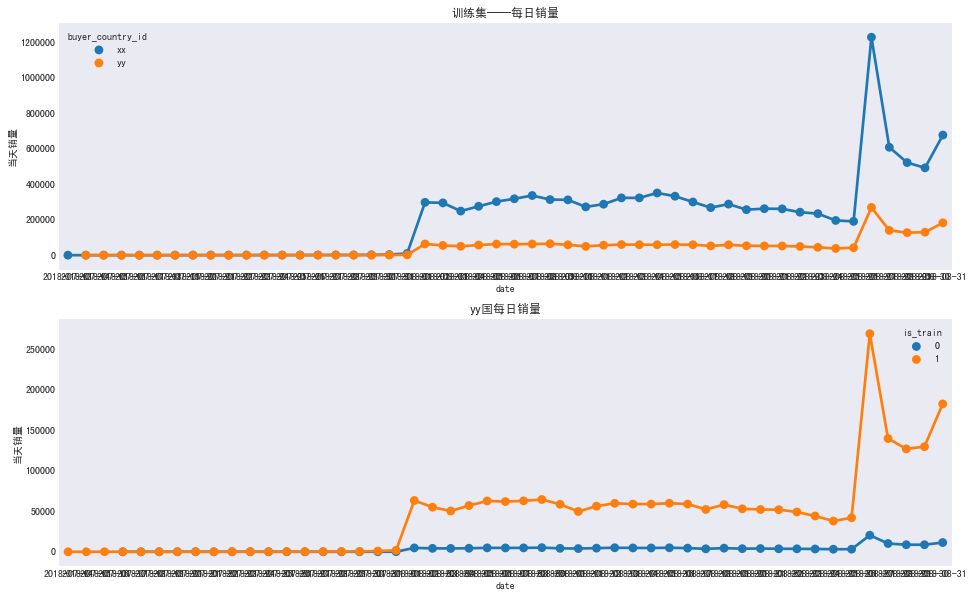

In [27]:
fig, ax = plt.subplots(2, 1, figsize=(16,10))
sns.pointplot(x='date', y='当天销量', hue='buyer_country_id', data=date_cnt[(date_cnt['is_train']==1)], 
            estimator=np.mean, ax=ax[0]).set_title('训练集——每日销量')

sns.pointplot(x='date', y='当天销量', hue='is_train', data=date_cnt[(date_cnt['buyer_country_id']=='yy')], 
            estimator=np.mean, ax=ax[1]).set_title('yy国每日销量')

In [27]:
test = pd.read_csv(path+'Antai_AE_round1_test_20190626.csv')
tmp = test[test['irank']<=31].sort_values(by=['buyer_country_id', 'buyer_admin_id', 'irank'])[['buyer_admin_id','item_id','irank']]
sub = tmp.set_index(['buyer_admin_id', 'irank']).unstack(-1)
sub.fillna(5595070).astype(int).reset_index().to_csv('./sub.csv', index=False, header=None)

In [28]:
# 最终提交文件格式
sub = pd.read_csv('./sub.csv', header = None)
sub.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,152,8410857,7937154,8472223,4016066,9891513,8064216,8351840,5595070,5595070,...,5595070,5595070,5595070,5595070,5595070,5595070,5595070,5595070,5595070,5595070
1,282,11721802,7665423,7665423,10808393,11310708,623582,6547607,2605373,688799,...,5595070,5595070,5595070,5595070,5595070,5595070,5595070,5595070,5595070,5595070
2,321,1461800,7379845,9243286,7379845,627849,5000759,11774753,10932288,4813286,...,5595070,5595070,5595070,5595070,5595070,5595070,5595070,5595070,5595070,5595070
3,809,2347616,5707010,6339286,5492003,1207574,5707010,5492003,1207574,2262443,...,5595070,5595070,5595070,5595070,5595070,5595070,5595070,5595070,5595070,5595070
4,870,11382694,5999244,6611583,7412272,4343647,5546383,3432696,9589237,6163411,...,5595070,5595070,5595070,5595070,5595070,5595070,5595070,5595070,5595070,5595070


In [ ]:
! ls /home/tianchi

In [ ]:
#! mv /home/tianchi/sub.csv /home/tianchi/myspace/
